# Computer Assignment 3 -- Group 2
* Ali Bemani
* Oscar Bautista Gonzalez
* Martin Hellkvist

Consider the optimization problem 

$$  \min_{W_1, W_2, w_3} \frac{1}{N} \sum_{i\in[N]} \lVert w_3 s(W_2 s(W_1 x_i)) - y_i \rVert_2^2,  $$
where $$ s(x) = 1/(1 + \exp(-x)) . $$ You may add your choice of regularizer.
Using the "Inividual household electri power consumption" and "Greenhouse Gas Observing Network" datasets, address the following questions.

a) Try to solve this optimization task with proper choices of size of decision variables ($W_1, W_2, w_3$) using GD, 
perturbed GD,
SGD,
SVRG and block coordinate descent.
For the SGD method, you may use the mini-batch version.

b) Compare these solvers in terms of complexity of hyper-parameter tuning,
convergence time, 
convergence rate (in terms of # outer-loop iterations), 
and memory requirement.

   ## Implementation

In [1]:
##imports from libraries
import pandas as pd
import numpy as np
import time
import math
import sys
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from IPython.core.debugger import set_trace


# the "resource" library is not available on windows. 
# if it can be imported, we can use it! For example, while running on google colab
try:
    import resource
    print("Succesfully imported 'resource' package")
except:
    print("Failed on importing 'resource' package, continuing wihtout it!")

Failed on importing 'resource' package, continuing wihtout it!


## Load Data and preprocess

### Load Greenhouse data

In [2]:
N_sites = 70
N_cols = 327
dghg = 15 # input length for data
Nghg = N_sites * N_cols
ghgdata = np.zeros((dghg+1, Nghg))

pathprefix = "./Data/ghg_data/ghg_data/ghg.gid.site"
for i in range(N_sites):
    filename = pathprefix + str(i + 1).zfill(4) + ".dat"
    subdata = np.genfromtxt(filename, delimiter=" ")
    ghgdata[:,i*N_cols:(i+1)*N_cols] = subdata

ghgdata = ghgdata.T

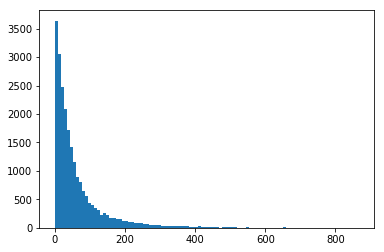

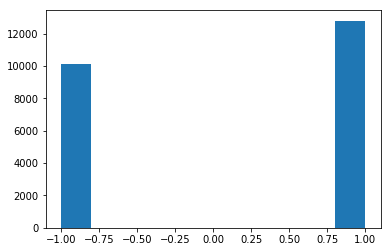

In [3]:
Xg = ghgdata[:, 0:dghg]
Yg = ghgdata[:, [dghg]]
plt.figure(1)
_ = plt.hist(Yg, bins=100)

# threshold Y to binary
threshold = 30
mask = Yg < threshold
Yg[mask] = -1
Yg[~mask] = 1
plt.figure(2)
_ = plt.hist(Yg)

Ng = Xg.shape[0]
assert Xg.shape[1] == dghg
assert Yg.shape[0] == Ng

### Load Household data

In [4]:
data = pd.read_csv("./Data/household_power_consumption/household_power_consumption.txt", sep=";", low_memory=False)

In [5]:
data.dropna(axis=0, inplace=True)

Xh = data.iloc[:, 3:9]
yh = data.iloc[:, 2]

print(Xh.isna().sum())
print(yh.isna().sum())

Xh = Xh.to_numpy(dtype = np.dtype).astype(np.float)
yh = yh.to_numpy(dtype = np.dtype).astype(np.float).reshape(-1,1) # make as column vector of dimension (N,1)

Nh, dh = Xh.shape
assert yh.shape[0] == Nh

Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64
0


## Implementation

### Define Cost Function and its Gradient

We use the Least Squares cost with the output estimate from a neural network:

$$L(x,y; W_1, W_2, w_3) = \frac{1}{N} \sum_{i\in[N]} (  w_3 s(W_2 s(W_1 x_i)) - y_i )^2,$$

where $s$ is the sigmoid function.

We will be using the following definitions:


$$ \begin{align} 
    & z^{(1)}_i = W^{(1)} x_i \\ 
    & a^{(1)}_i = s(z^{(1)}_i) \\ 
    & z^{(2)}_i = W^{(2)} a^{(1)}_i \\
    & a^{(2)}_i = s(z^{(2)}_i) \\
    & \hat{y}_i = w^{(3)} a^{(2)}_i
    \end{align}$$

The gradient w.r.t. $w^{(3)}$ is 

$$ \frac{\partial L}{\partial w^{(3)}} = 
\frac{\partial L}{\partial \hat{y}} 
\frac{\partial \hat{y}}{\partial w^{(3)}} = 
2(\hat{y} - y)(a^{(2)})^T = \delta^0 (a^{(2)})^T. $$

The gradient w.r.t. $W^{(2)}$ is 

$$ \frac{\partial L_i}{\partial W^{(2)}} = 
\frac{\partial L}{\partial \hat{y}}
\frac{\partial \hat{y}}{\partial a^{(2)}}
\frac{\partial a^{(2)}}{\partial z^{(2)}}
\frac{\partial z^{(2)}}{\partial W^{(2)}} = 
\delta^1  \delta^0  (a^{(1)})^T. $$

The gradient w.r.t. $W^{(1)}$ is

$$ \frac{\partial L_i}{\partial W^{(1)}} = 
\frac{\partial L}{\partial \hat{y}}
\frac{\partial \hat{y}}{\partial a^{(2)}}
\frac{\partial a^{(2)}}{\partial z^{(2)}}
\frac{\partial z^{(2)}}{\partial a^{(1)}}
\frac{\partial a^{(1)}}{\partial z^{(1)}}
\frac{\partial z^{(1)}}{\partial W^{(1)}}
= \delta^2 \delta^1 \delta^0x^T. $$

Definitions:
$$\delta^0 = 2(\hat{y} - y) \in R^{1\times 1},~~\delta^1=(W^{(3)} diag(s'(z^{(2)})))^T,~~\delta^2=(W^{(2)} diag(s'(z^{(1)})))^T $$

In [61]:
def initialize_network(n_inputs, N_hidden_layers, n_hidden_layers, seed=0):
    """ Initialize a NN with n_inputs inputs, 
    N_hidden_layers number of hidden layers, 
    n_hidden_layers is size of each hidden layer"""
    np.random.seed(seed)
    
    network = list()
    
    input_layer = [{"input": np.random.random(size=(n_hidden_layers, n_inputs))}]
    network.append(input_layer)
    
    for i in range(1, N_hidden_layers):
        hidden_deep = [{"W"+str(i+1): np.random.random(size=(n_hidden_layers, n_hidden_layers))}]
        network.append(hidden_deep)
    
    output = [{"output": np.random.random(size=(1, n_hidden_layers))}]
    network.append(output)
    
    return network

In [7]:
# define getter and setter functions for the network
def get_values(layer):
    return list(layer[0].values())[0]
def get_key(layer):
    return list(layer[0].keys())[0]
def get_dim_layer(layer):
    return get_values(layer).shape
def get_num_layers(network):
    return len(network)
def set_values(W, network, index):
    layer = network[index]
    key = get_key(layer)
    layer[0][key] = W

In [8]:
def nn_forward(x, network):
    #### Wants input as column vector (d, 1)
    d = x.shape[0]
    assert d == get_values(network[0]).shape[1]
    Z_ = list()
    A_ = [x]
    for layer in network:
        W = get_values(layer)
        key = get_key(layer)
        if (key == "input"):
            z = W @ x
        elif (key == "output"):
            y_hat = W @ a_
            break
        else:
            z = W @ a_
        a_ = sigmoid(z)
        Z_.append(z)
        A_.append(a_)
    return y_hat, Z_, A_

In [9]:
def sigmoid(x):
    return 1.0/(1.0 + np.exp(-x))
def sigmoid_prime(x):
    s = sigmoid(x)
    return s*(1 - s)

$$\delta^0 = 2(\hat{y} - y) \in R^{1\times 1},~~\delta^1=(W^{(3)} diag(s'(z^{(2)})))^T,~~\delta^2=(W^{(2)} diag(s'(z^{(1)})))^T $$

In [10]:
def nn_backward_prop(network, X, Y):
#     set_trace()
    N_data = X.shape[0]
    d_out = Y.shape[1]
    assert Y.shape[0] == N_data
    
    N_layers = get_num_layers(network)
    
    Y_hat_ = np.zeros((N_data, d_out))
    
    G_ = []
    
    for layer in network:
        G_.append(np.zeros(get_dim_layer(layer)))
    
    # compute all estimates
    for i in range(N_data):
        x = X[[i], :].T
        y = Y[[i], :].T
        y_hat, Z_, A_ = nn_forward(x, network)
        Y_hat_[i] = y_hat
        
        err_ = y_hat - y
        
        delta_ = [2*err_]
        for i in reversed(range(1, N_layers)): # 2, 1
            W = get_values(network[i])
            z = Z_[i-1]
            s_prime = sigmoid_prime(z).flatten()
#             set_trace()
            delta = (W @ np.diag(s_prime)).T
            delta_.append(delta)
            
        D = np.identity(np.max(delta_[0].shape)) # initialize D
#         set_trace()
        for i in reversed(range(N_layers)): # 2, 1, 0
            D = delta_[N_layers - (i+1)] @ D
#             set_trace()
            G_[i] += D @ A_[i].T
    return G_

In [11]:
def cost(X, Y, network):
    N = X.shape[0]
    assert Y.shape[0] == N
    cost = 0
    for i in range(N):
        x = X[[i], :].T
        y = Y[[i], :].T
#         set_trace()
        y_hat, _, _ = nn_forward(x, network)
        cost += (1/N) * (y_hat - y)**2
    return cost

In [82]:
def solver(X, Y, X_test, Y_test, network, alpha, num_iters, lambda_, epsilon, optimizer = "GD", mem=False, return_cost=False, verbose=True):
    stop_flag = 1
    
    cost_ = np.zeros(num_iters+1)
    if return_cost:
        cost_[0] = cost(X_test, Y_test, network)
    
    if (optimizer == "GD"):
        for i in range(num_iters):
            G_ = nn_backward_prop(network, X, Y) # compute the exact gradient wrt w, given x and y
            for k, g in enumerate(G_):
                W = get_values(network[k])
                W = W - alpha * g # GD update
                set_values(W, network, k)
                
            if return_cost:
#                 set_trace()
                cost_[i+1] = cost(X_test, Y_test, network)
                
#             if (np.linalg.norm(g) <= epsilon):
#                 print("GD: Stop on condition fulfilled! Number of iterations: ", i+1, "/", num_iters)
#                 stop_flag = 0
#                 break
        if (verbose) and (stop_flag):
            print("GD: Number of iterations: ", num_iters, "/", num_iters)
            print("GD: final norm: ", np.linalg.norm(g))
                
    elif (optimizer == "SGD"):
        N, d = X.shape
        assert Y.shape == (N,1)
        for i in range(num_iters):
            i_ = int(N*np.random.rand(1))
            x_ = X[[i_], :]
            y_ = Y[[i_], :]
            
            G_ = nn_backward_prop(network, x_, y_) # compute the exact gradient wrt w, given x and y
            for k, g in enumerate(G_):
                W = get_values(network[k])
                W = W - alpha * g # GD update
                set_values(W, network, k)
                
            if return_cost:
#                 set_trace()
                cost_[i+1] = cost(X_test, Y_test, network)
                
    elif (optimizer == "SVRG"):
        N, d = x.shape
        assert y.shape == (N,1)
        
        T = 1000 # epoch length
        K = math.floor(num_iters/T) # number of epochs, given number of iterations
        
        if K == 0:
            # only run for one epoch consisting of num_iters iterations
            K = 1
            T = num_iters
        if verbose:
            print("number of epochs: ", K)
        cost_ = np.zeros(T*K)
        
        for k in range(K):
            yx = y * x # (N, d)
            yxw = yx @ w # (N, 1)
            
            assert yx.shape == (N, d)
            assert yxw.shape == (N, 1)
            
            # G_ is equal to using function_gradient, but we need G_vec, so we compute it manually here
            exp_vec = 1/(1 + np.exp(yxw)) # (N, 1)
            
            G_vec = (-yx * exp_vec).reshape(d, N) + 2*lambda_*w # (d, N)
                                    
            G_ = (1/N) * np.sum(G_vec, axis=1, keepdims=1) # (d, 1)
            if (np.linalg.norm(G_) <= epsilon): # check the average gradient
                print("SVRG: Stop on condition fulfilled! Number of iterations: ", k*t, "/", num_iters)
                break
            
            assert G_vec.shape == (d, N)
            assert G_.shape == (d, 1)
            
            for t in range(T):
                i_ = int(N*np.random.rand(1))
                x_ = x[[i_], :] # (1, d)
                y_ = y[[i_], :] # (1, 1)
                g = function_gradient(x_, y_, w, lambda_) # (d, 1)
                assert g.shape == (d,1)
                assert G_vec[:, [i_]].shape == (d,1)
                assert G_.shape == (d,1)
                w = w - alpha*(g - G_vec[:, [i_]] + G_)
                
                if return_cost:
                    cost_[t + k*T] = cost(X_test, Y_test, w, lambda_)
                    
                if (t%10==0) and (mem) and ('resource' in sys.modules) and (verbose):
                    usage=resource.getrusage(resource.RUSAGE_SELF)
                    print("mem for SVRG (mb):", (usage[2]*resource.getpagesize())/1000000.0)
                    
        if (K > 0) and (verbose):
            print("SVRG: final norm: ", np.linalg.norm(g))
            
    elif (optimizer == "SAG"):
        N, d = x.shape
        assert y.shape == (N,1)
        
        # compute initial gradient estimates for all datapoints
        yx = y * x # (N, d)
        yxw = yx @ w # (N, 1)
        exp_vec = 1/(1 + np.exp(yxw)) # (N, 1)
        G_vec = np.zeros((d, N))
        cost_ = np.zeros(num_iters)
        g_avg = np.zeros((d,1))
        for k in range(num_iters):
            i_ = int(N*np.random.rand(1))
            x_ = x[[i_], :] # (1, d)
            y_ = y[[i_], :] # (1, 1)
            g = function_gradient(x_, y_, w, lambda_) # (d, 1)
            g_avg = g_avg - G_vec[:, [i_]] + g
            G_vec[:, [i_]] = g # (d, N)
            w = w - (alpha/N) * g_avg
            if return_cost:
                cost_[k] = cost(X_test, Y_test, w, lambda_)
                
            if (np.linalg.norm(g) <= epsilon):
                    print("SAG: Stop on condition fulfilled! Number of iterations: ", k, "/", num_iters)
                    break
                    
            if (k%10==0) and (mem) and ('resource' in sys.modules) and (verbose):
                    usage=resource.getrusage(resource.RUSAGE_SELF)
                    print("mem for SAG (mb):", (usage[2]*resource.getpagesize())/1000000.0)
        if verbose:
            print("final norm: ", np.linalg.norm(g))
    if return_cost:
        return cost_

## Run on GHG observations

In [40]:
N_train = 1000
N_test = 1000
X_train = Xg[0:N_train, :]
Y_train = Yg[0:N_train, :]
X_test = Xg[N_train:N_train + N_test, :]
Y_test = Yg[N_train:N_train+N_test, :]

d = X_train.shape[1] # input size
n_hidden_layers = 2 # number of hidden layers
d_hidden = 2*d # number of neuron in each hidden layer

# plt.figure()
# plt.hist(Y_train)
# plt.figure()
# plt.hist(Y_test)

### GD

GD: Number of iterations:  100 / 100
GD: final norm:  0.21433418767223253
Final cost: 0.7472514998201786


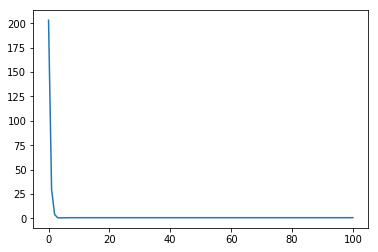

In [87]:
np.set_printoptions(precision=None)
network_init = initialize_network(d, n_hidden_layers, d_hidden, seed=0)
alpha = 1e-5
num_iters = 100
lambda_ = 0
epsilon = 0
cost_GD = solver(X_train, Y_train, X_test, Y_test, network_init, alpha, num_iters, lambda_, epsilon, optimizer = "GD", mem=False, return_cost=True, verbose=True)
plt.plot(cost_GD)
ax = plt.gca()
ax.get_yaxis().get_major_formatter().set_useOffset(False)
print("Final cost:", cost_GD[-1])

final cost: 0.7472514998201786


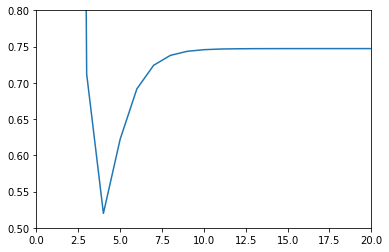

In [88]:
plt.plot(cost_GD)
ax = plt.gca()
ax.get_yaxis().get_major_formatter().set_useOffset(False)
plt.xlim(0,20)
plt.ylim(0.5,.8)
print("final cost:", cost_GD[-1])

### SGD

Final cost: 0.6987012373250375


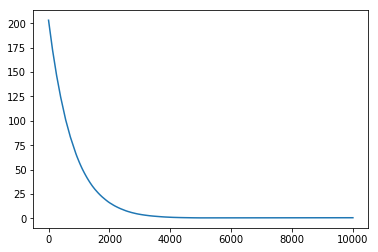

In [97]:
np.set_printoptions(precision=None)
network_init = initialize_network(d, n_hidden_layers, d_hidden, seed=0)
alpha = 1e-5
num_iters = 10000
lambda_ = 0
epsilon = 0
cost_SGD = solver(X_train, Y_train, X_test, Y_test, network_init, alpha, num_iters, lambda_, epsilon, optimizer = "SGD", mem=False, return_cost=True, verbose=True)
plt.plot(cost_SGD)
ax = plt.gca()
ax.get_yaxis().get_major_formatter().set_useOffset(False)
print("Final cost:", cost_SGD[-1])

Final cost: 58.16711674987604


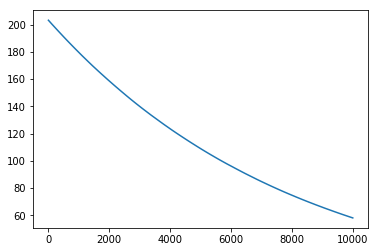

In [98]:
np.set_printoptions(precision=None)
network_init = initialize_network(d, n_hidden_layers, d_hidden, seed=0)
alpha = 1e-6
num_iters = 10000
lambda_ = 0
epsilon = 0
cost_SGD = solver(X_train, Y_train, X_test, Y_test, network_init, alpha, num_iters, lambda_, epsilon, optimizer = "SGD", mem=False, return_cost=True, verbose=True)
plt.plot(cost_SGD)
ax = plt.gca()
ax.get_yaxis().get_major_formatter().set_useOffset(False)
print("Final cost:", cost_SGD[-1])